# Deep Domain Adaptation with the PACS dataset
## using built from scratch Domain Adversarial Neural Network (DANN)

This homework was completed as a part of the homeworks for the Machine Learning and Deep Learning course of the Data Science and Engineering Master's Degree at Politecnico di Torino.

In this homework we will work with the **PACS dataset**, which is composed of 7 categories of images and 4 different domains (**P**hoto, **A**rt Painting, **C**artoon, **S**ketch).

The purpose of this homework is to build a **Domain Adversarial Neural Network (DANN)** using the pretrained layers of the **AlexNet** in order to achieve **domain adaptation on images belonging to other domains**. <br/> 
> The AlexNet model was chosen for this homework because we will work with **images**, while the original DANN is used to recognize **digits**. <br/>
Moreover, the **source dataset** we will use is the **Photo** domain of the PACS dataset, that contains images from the same domain of the ImageNet dataset (which was used to train the AlexNet).

To do so, I ran different experiments:

* Train the network **without adaptation** on a **source domain** and test on a **target domain**
* Train the network **with adaptation** on a **source domain** and on a **target domain** and test on the latter
* Hyperparameters tuning, training **with** and **without adaptation** first on a **target domain T1** and then on a **target domain T2**, then testing the quality of the network with these parameters on a **target domain T**

Finally, it was possible to infer some **comparisons between the different network performances**, with or without **domain adaptation**.


## PACS dataset
The **PACS dataset** (**P**hoto, **A**rt Painting, **C**artoon, **S**ketch) is made up of 4 domains which are very shifted among them.<br/> 
In the following figure, for example, we can see how different can be a picture in different domains.<br/>

![title](pacs.png)

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

!rm -rf "./DANN"
#!rm -rf "./PACS"

import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import ImageFolder

from PIL import Image
from tqdm import tqdm

import numpy as np
from google.colab import output

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

output.clear()

### Set arguments, define Data Preprocessing, prepare dataset and dataloaders

The default arguments used for this homework are:

* **DEVICE** = 'cuda'
* **NUM_CLASSES** = 7
* **BATCH_SIZE** = 256 
* **LR** = 0.0001           
* **MOMENTUM** = 0.9      
* **WEIGHT_DECAY** = 5e-5  
* **NUM_EPOCHS** = 20
* **STEP_SIZE** = 10   
* **GAMMA** = 0.2   
* **LOG_FREQUENCY** = 10
* **IMAGE_SIZE** = 224

Also, the basic transformations applied on the whole dataset are:

* **Resizing** the input PIL image to 256
* **Crop** a central square patch of 224 in order to fit AlexNet requirements 
  (3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.)
* **Transform** the image into torch.Tensor
* **Normalize** the image with mean and standard deviation
  [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
  
The dataset is prepared by means of the ImageFolder class from PyTorch.



In [0]:
loader = Loader()
util = Utility()
manager = TrainValidateTestManager()

DEVICE, NUM_CLASSES, NUM_DOMAINS, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, IMAGE_SIZE = loader.load_default_parameters()
 
train_transform, test_transform = loader.load_default_transformations()

loader.clone_repositories()
from DANN.DANN import RandomNetworkWithReverseGrad

output.clear()

## Implementing the Model
![title](dann.png)

The code of my custom implementation of the **Domain Adversarial Neural Network** can be found [here](https://github.com/cpeluso/HW3-Deep-Domain-Adaptation/blob/master/DANN.py).

The DANN is composed by:
* The **feature extractor** part - the convolutional layers of the AlexNet model.
* The **label predictor** part - the fully connected layers of the AlexNet model. <br/>
    This part is intended to assign a class (between the 7 of the dataset) to the images that pass through it.
* The **domain classifier** part - the fully connected layers of the AlexNet model. <br/>
    This part is intended to assign a domain (between the 2 used for each training run) to the images that pass through it.
    
All these 3 branches are initialized with the corresponding weights of the pretrained AlexNet.

***

The **Domain Adversarial Neural Network** technique works using a **domain confusion loss**. <br/>
Its goal is to let the distributions of **source** and **target** domains align. <br/>
Following this approach, we can obtain a network that is able to generalize the features of different data domains.

![title](distributions.png)

In particular, the **DANN** network tries to make the features indistinguishable for the label classifier (predictions must be made based on features that cannot discriminate between the source and target domains) using two losses: the **classification loss** and the **domain confusion loss**.<br/>

The approach promotes the emergence of features that are 
* **discriminative** for the main learning task on the source domain
* **indiscriminative** with respect to the shift between the domains

by minimizing the classification loss for the source samples and the domain confusion loss for all samples (maximizing the domain confusion loss for the feature extraction thanks to a **gradient reversal layer**).

The **gradient reversal layer** is characterized by a **alpha**/**lambda** parameter that corresponds to the weight of the reversed backpropagation. <br/>
This parameter highly affects the accuracy, so in the next steps we will try to optimize it.




In [11]:
dann

RandomNetworkWithReverseGrad(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featur

## Domain Adaptation
### Train on Photo, and Test on Art painting without adaptation

In this step of the project, I trained the **DANN** network without using the **domain classifier** branch (so, it is a standard AlexNet), passing only **Photo** domain images. 

As we expected, the **training accuracy** (blue line) was really high, because the AlexNet was already pretrained on the same domain of the **Photo** images. 

However, we can also see that the **validation accuracy** (red line) on **Art Painting** images doesn't go higher than the 47% circa.

Another important information that we can extract from this plot (and that we will confirm also later) is that that accuracy doesn't increase from a certain epoch.

Finally, I tested the network only on the target domain, **Art Painting**: the final accuracy is **47.265%**.

<Figure size 432x288 with 0 Axes>

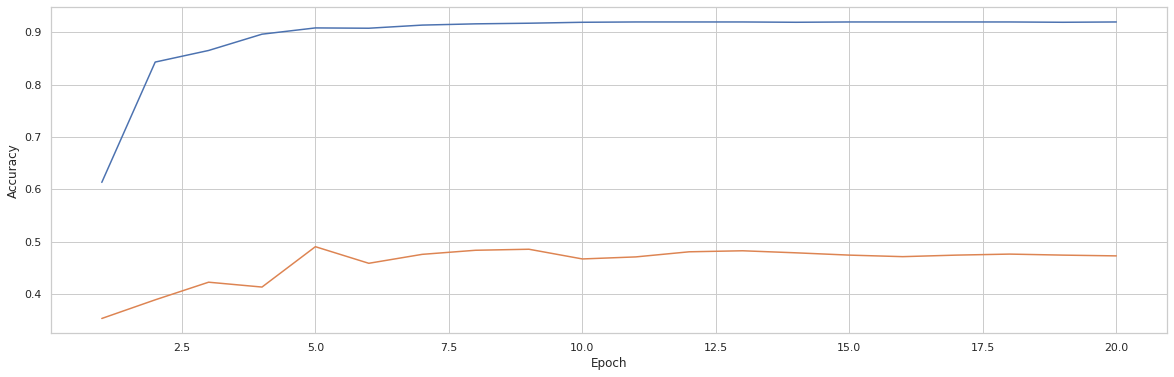

<Figure size 432x288 with 0 Axes>

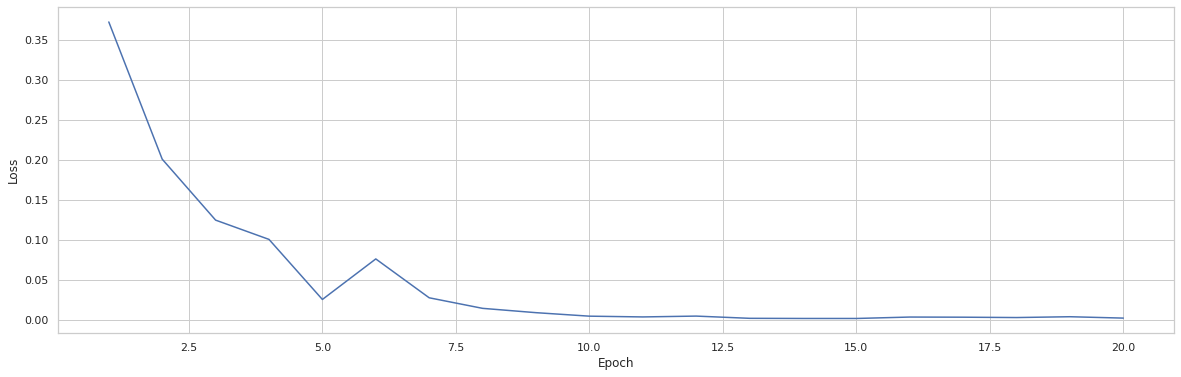

In [0]:
train_dataset, test_dataset, cartoon_dataset, sketch_dataset = loader.load_datasets()
dataloader_source, dataloader_target, dataloader_target_cartoon, dataloader_target_sketch = loader.load_dataloaders()

dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
optimizer_name = "Adam"
optimizer, scheduler = loader.load_scheduler_optimizer(dann, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = "Adam")

output.clear()

manager.train_network_without_adaptation_artpainting(dann, util)

model_filename = "model_lr_" + str(LR).replace(".", "") + "_alpha_null.pth"
model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/without_adaptation/{model_filename}"
torch.save(dann.state_dict(), model_path)

In [0]:
manager.test_network(dann, dataloader_target)

Test Accuracy: 0.47265625


### Train DANN on Photo and test on Art painting with DANN adaptation

After the training without adaptation step, I trained the **DANN** network also using the **domain classifier** branch, passing **Photo** and **Art Painting** domain images. 

For this step, I set the **lambda** parameter arbitrarily to **0.1**.

The **training accuracy** (blue line) and the **validation accuracy** (red line) on **Art Painting** images evolution doesn't change so much compared to the previous step.

We can confirm that the accuracies don't increase from a certain epoch.

Testing the network only on the target domain, **Art Painting**, the model accuracy is **48.437%**.

<Figure size 432x288 with 0 Axes>

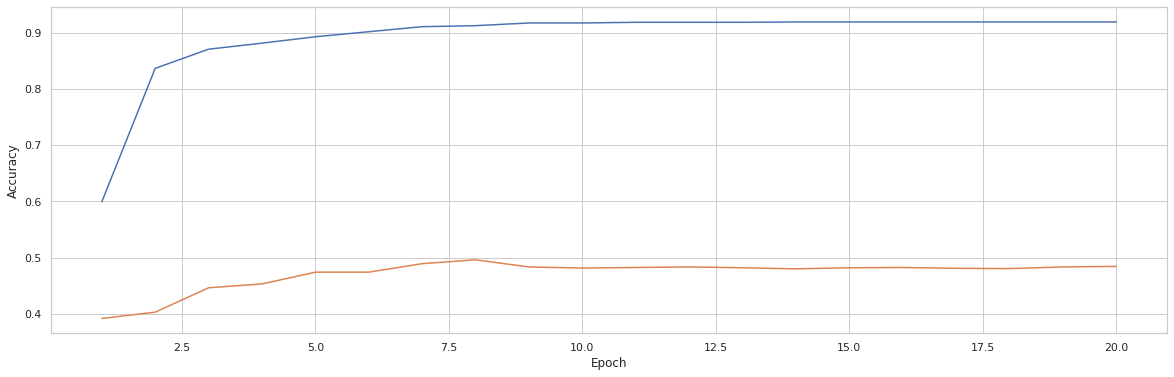

<Figure size 432x288 with 0 Axes>

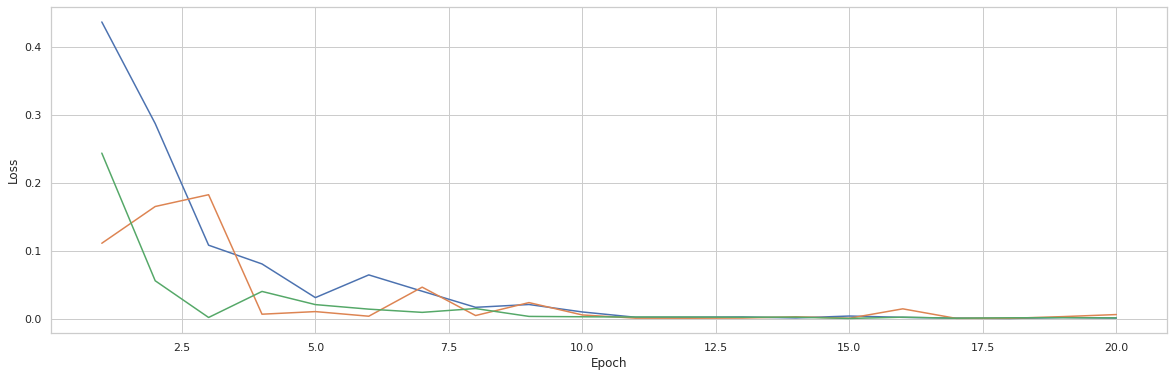

In [0]:
train_dataset, test_dataset, cartoon_dataset, sketch_dataset = loader.load_datasets()
dataloader_source, dataloader_target, dataloader_target_cartoon, dataloader_target_sketch = loader.load_dataloaders()

dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
optimizer, scheduler = loader.load_scheduler_optimizer(dann, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = optimizer_name)

output.clear()

discriminator_source_labels, discriminator_target_labels  = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE), torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo, Discriminator label to Art Painting
discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

LAMBDA = 0.1

manager.train_network_with_adaptation_artpainting(dann, util, LAMBDA)

model_filename = "model_lr_" + str(LR).replace(".", "") + "_alpha_" + str(LAMBDA).replace(".", "") + ".pth"
model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/with_adaptation/{model_filename}"
torch.save(dann.state_dict(), model_path)

In [0]:
manager.test_network(dann, dataloader_target)

Test Accuracy: 0.484375


### Compare results

Even if a small increase of the accuracy on PACS dataset is a good improvement, **there is not a discernable performance increasing when training the full DANN network with domain adaptation**.

So, in order to try to rise the validation accuracy, we will perform **hyperparameters tuning** in the next steps.

***

### Hyperparameters Tuning: Train without adaptation

In order to perform a grid search, trying to increase the accuracy on target domain **Art Painting**, I used the following hyperparameters combinations:

Learning Rate | Optimizer |
--- | --- |
0.0001|SGD|
0.0001|Adam|
0.0005|SGD|
0.0005|Adam|
0.001|SGD|
0.001|Adam|
0.01|SGD|
0.01|Adam|

The best hyperparameters search approach used is the following:
* Train the network **without adaptation** on **Cartoon domain** with all the previous explained hyperparameters combination.<br/> Save up the max validation accuracy found **for each hyperparameter tuple**.
* Train the network **without adaptation** on **Sketch domain** with all the previous explained hyperparameters combination.<br/> Save up the max validation accuracy found **for each hyperparameter tuple**.
* Plot an heatmap to visualize the different max accuracies between hyperparameters, for **Cartoons** and **Sketches**.
* Choose the best hyperparameter tuple using the formula:<br/>
    * Compute all max accuracies averages and retrieve the hyperparameter combination associated to the max average accuracy:
        \begin{equation}
        \\ \text{ }
        \\ \text{Where } 
        \\ i = \{\text{hyperparameters_combination}_0, ..., \text{hyperparameters_combination}_{H-1} \} 
        \\ H = \text{Number of hyperparameters combinations}
        \\ \text{ }
        \\ \text{Max accuracy averages} = \frac{\text{max_accuracy}_{\text{Cartoon}}[i] + \text{max_accuracy}_{\text{Sketch}}[i]}{2} \text{, for all } i
        \\ \text{Best hyperparameter combination} = \arg \max \{\text{Max accuracy averages}\}
        \\ \text{ }
        \end{equation}
* Train the network **without adaptation** on **Art Painting domain** with the best hyperparameter combination found in the previous step.
* Test the network on **Art Painting domain**.

#### Results

The **best hyperparameter combination** found is

Learning Rate | Optimizer |
--- | --- |
0.01|SGD|

However, this approach **didn't pay off that much**: <br/>
the accuracy before **hyperparameters tuning** was **47.265%** and with the best hyperparameters found the model reached **47.558%** of accuracy on validation set.

In [13]:
train_dataset, test_dataset, cartoon_dataset, sketch_dataset = loader.load_datasets()
dataloader_source, dataloader_target, dataloader_target_cartoon, dataloader_target_sketch = loader.load_dataloaders()

DEVICE, NUM_CLASSES, NUM_DOMAINS, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, IMAGE_SIZE = loader.load_hyperparameters_tuning_parameters()

hyperparameters_set = loader.load_hyperparameters_set_without_adaptation_training()
validation_accuracies_cartoon = dict()

grid_search_advancement = []

for lr in hyperparameters_set[0]:

  for optimizer_name in hyperparameters_set[1]:

    validation_accuracies_cartoon[(lr, optimizer_name)] = []

    dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
    loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
    optimizer, scheduler = loader.load_scheduler_optimizer(dann, lr, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = optimizer_name)

    validation_accuracies_cartoon[(lr, optimizer_name)] = manager.train_network_without_adaptation_cartoon(dann, util)

    # model_filename = "model_lr_" + str(lr).replace(".", "") + "_optimizer_name_" + str(optimizer_name).replace(".", "") + ".pth"
    # model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/hyperparameters_tuning_cartoon/{model_filename}"
    # torch.save(dann.state_dict(), model_path)

    this_max_accuracy = sorted(validation_accuracies_cartoon[(lr, optimizer_name)], reverse=True)[0]
    this_run = "Cartoon - LR: ", lr, ", optimizer name: ", optimizer_name, ", max accuracy (validation): ", this_max_accuracy
    grid_search_advancement.append(this_run)
    
    for run in grid_search_advancement:
      print(run)

    print("- - - - - - ")

('Cartoon - LR: ', 0.0001, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.2713310580204778)
('Cartoon - LR: ', 0.0001, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.3575085324232082)
('Cartoon - LR: ', 0.001, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.2815699658703072)
('Cartoon - LR: ', 0.001, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.2696245733788396)
('Cartoon - LR: ', 0.005, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.3127133105802048)
('Cartoon - LR: ', 0.005, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.1727815699658703)
('Cartoon - LR: ', 0.01, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.3058873720136519)
('Cartoon - LR: ', 0.01, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.19496587030716722)
- - - - - - 


In [14]:
validation_accuracies_sketch = dict()

grid_search_advancement = []

for lr in hyperparameters_set[0]:

  for optimizer_name in hyperparameters_set[1]:

    validation_accuracies_sketch[(lr, optimizer_name)] = []

    dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
    loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
    optimizer, scheduler = loader.load_scheduler_optimizer(dann, lr, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = optimizer_name)

    validation_accuracies_sketch[(lr, optimizer_name)] = manager.train_network_without_adaptation_sketch(dann, util)

    # model_filename = "model_lr_" + str(lr).replace(".", "") + "_optimizer_name_" + str(optimizer_name).replace(".", "") + ".pth"
    # model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/hyperparameters_tuning_sketch/{model_filename}"
    # torch.save(dann.state_dict(), model_path)

    this_max_accuracy = sorted(validation_accuracies_sketch[(lr, optimizer_name)], reverse=True)[0]
    this_run = "Sketch - LR: ", lr, ", optimizer name: ", optimizer_name, ", max accuracy (validation): ", this_max_accuracy
    grid_search_advancement.append(this_run)
    
    for run in grid_search_advancement:
      print(run)
    
    print("- - - - - - ")

('Sketch - LR: ', 0.0001, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.23110206159328073)
('Sketch - LR: ', 0.0001, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.18452532451005346)
('Sketch - LR: ', 0.001, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.18936116060066174)
('Sketch - LR: ', 0.001, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.2509544413336727)
('Sketch - LR: ', 0.005, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.21226775260880631)
('Sketch - LR: ', 0.005, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.1916518198014762)
('Sketch - LR: ', 0.01, ', optimizer name: ', 'SGD', ', max accuracy (validation): ', 0.3072028505981166)
('Sketch - LR: ', 0.01, ', optimizer name: ', 'Adam', ', max accuracy (validation): ', 0.09493509798931025)
- - - - - - 


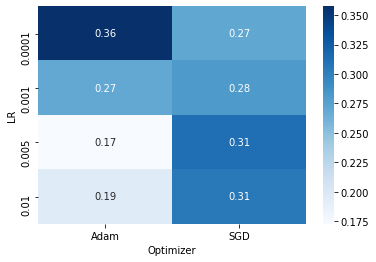

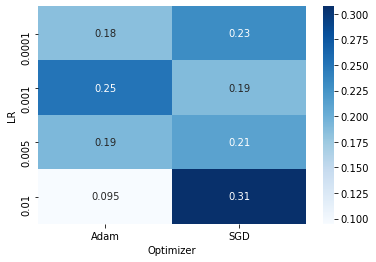

In [15]:
max_validation_accuracy_cartoon = dict()
max_validation_accuracy_sketch = dict()

for key in validation_accuracies_cartoon:
    max_validation_accuracy_cartoon[key] = sorted(validation_accuracies_cartoon[key], reverse=True)[0]

for key in validation_accuracies_sketch:   
    max_validation_accuracy_sketch[key] = sorted(validation_accuracies_sketch[key], reverse=True)[0]

grid_search_cartoon = []
for key in max_validation_accuracy_cartoon:
    grid_search_cartoon.append( (key[0], key[1], max_validation_accuracy_cartoon[key]) )
    
cartoon = pd.DataFrame(grid_search_cartoon, columns =['LR', 'Optimizer', 'Accuracy'])
cartoon_pivot = cartoon.pivot(index='LR', columns='Optimizer', values='Accuracy')
ax = sns.heatmap(cartoon_pivot,annot=True, cmap="Blues")

plt.show()

grid_search_sketch = []
for key in max_validation_accuracy_sketch:
    grid_search_sketch.append( (key[0], key[1], max_validation_accuracy_sketch[key]) )
    
sketch = pd.DataFrame(grid_search_sketch, columns =['LR', 'Optimizer', 'Accuracy'])
sketch_pivot = sketch.pivot(index='LR', columns='Optimizer', values='Accuracy')
ax = sns.heatmap(sketch_pivot,annot=True, cmap="Blues")

In [16]:
avg_validation_accuracy = dict()

for key in max_validation_accuracy_cartoon:
    avg_validation_accuracy[key] = (max_validation_accuracy_cartoon[key] + max_validation_accuracy_sketch[key]) / 2

lr, optimizer_name = [key for key in avg_validation_accuracy if avg_validation_accuracy[key] == sorted(avg_validation_accuracy.values(), reverse=True)[0]][0]

print(lr, optimizer_name) # Best Parameters

0.01 SGD


<Figure size 432x288 with 0 Axes>

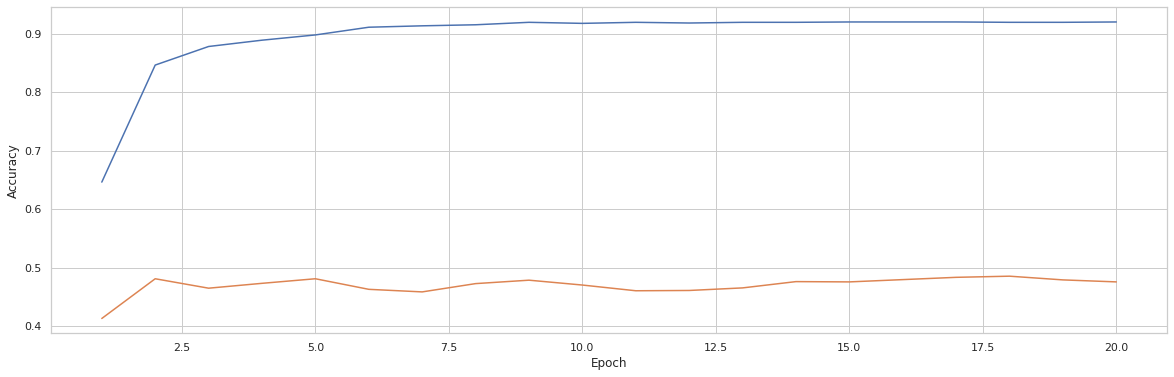

<Figure size 432x288 with 0 Axes>

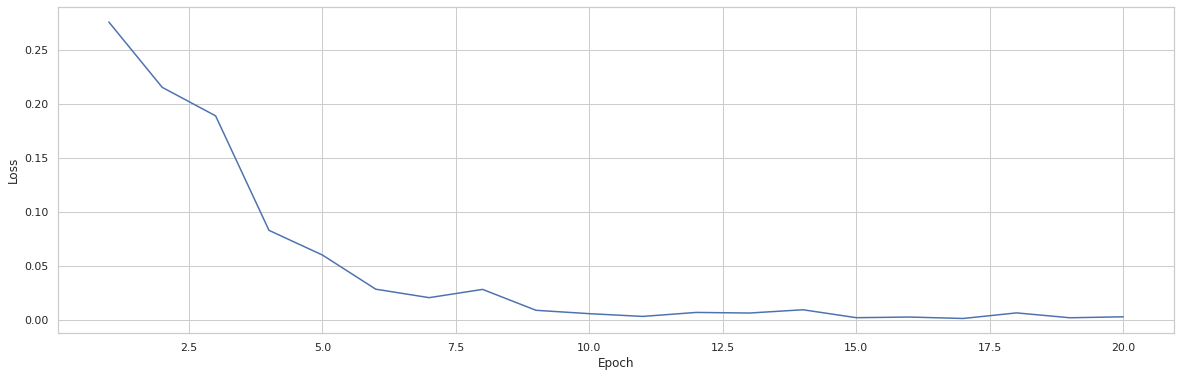

In [19]:
DEVICE, NUM_CLASSES, NUM_DOMAINS, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, IMAGE_SIZE = loader.load_default_parameters()

LR = lr

train_dataset, test_dataset, cartoon_dataset, sketch_dataset = loader.load_datasets()
dataloader_source, dataloader_target, dataloader_target_cartoon, dataloader_target_sketch = loader.load_dataloaders()

dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
optimizer, scheduler = loader.load_scheduler_optimizer(dann, lr, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = optimizer_name)

output.clear()

manager.train_network_without_adaptation_artpainting(dann, util)

# model_filename = "model_lr_" + str(LR).replace(".", "") + "_alpha_null.pth"
# model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/without_adaptation/{model_filename}"
# torch.save(dann.state_dict(), model_path)

In [1]:
manager.test_network(dann, dataloader_target)

Test Accuracy: 0.4755859375


### Hyperparameters Tuning: Train with adaptation

In order to perform a grid search, trying to increase the accuracy on target domain **Art Painting**, I used the following hyperparameters combinations:

Learning Rate | Alpha |
--- | --- |
0.0001|0.15|
0.0001|0.15|
0.0002|0.3|
0.0002|0.3|
0.0003|0.4|
0.0003|0.4|

The best hyperparameters search approach used is the following:
* Train the network **with adaptation** on **Cartoon domain** with all the previous explained hyperparameters combination.<br/> Save up the max validation accuracy found **for each hyperparameter tuple**.
* Train the network **with adaptation** on **Sketch domain** with all the previous explained hyperparameters combination.<br/> Save up the max validation accuracy found **for each hyperparameter tuple**.
* Plot an heatmap to visualize the different max accuracies between hyperparameters, for **Cartoons** and **Sketches**.
* Choose the best hyperparameter tuple using the formula:<br/>
    * Compute all max accuracies averages and retrieve the hyperparameter combination associated to the max average accuracy:
        \begin{equation}
        \\ \text{ }
        \\ \text{Where } 
        \\ i = \{\text{hyperparameters_combination}_0, ..., \text{hyperparameters_combination}_{H-1} \} 
        \\ H = \text{Number of hyperparameters combinations}
        \\ \text{ }
        \\ \text{Max accuracy averages} = \frac{\text{max_accuracy}_{\text{Cartoon}}[i] + \text{max_accuracy}_{\text{Sketch}}[i]}{2} \text{, for all } i
        \\ \text{Best hyperparameter combination} = \arg \max \{\text{Max accuracy averages}\}
        \\ \text{ }
        \end{equation}
* Train the network **with adaptation** on **Art Painting domain** with the best hyperparameter combination found in the previous step.
* Test the network on **Art Painting domain**.

#### Results

The **best hyperparameter combination** found is

Learning Rate | Alpha |
--- | --- |
0.0002|0.4|

However, this approach **didn't pay off at all**: <br/>
the accuracy before **hyperparameters tuning** was **48.438%** and with the best hyperparameters found the model falls at **38.379%** of accuracy on validation set.

In [0]:
train_dataset, test_dataset, cartoon_dataset, sketch_dataset = loader.load_datasets()
dataloader_source, dataloader_target, dataloader_target_cartoon, dataloader_target_sketch = loader.load_dataloaders()

DEVICE, NUM_CLASSES, NUM_DOMAINS, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, IMAGE_SIZE = loader.load_hyperparameters_tuning_parameters()

hyperparameters_set = loader.load_hyperparameters_set_with_adaptation_training()
validation_accuracies_cartoon = dict()

grid_search_advancement = []

for lr in hyperparameters_set[0]:

  for alpha in hyperparameters_set[1]:

    validation_accuracies_cartoon[(lr, alpha)] = []

    dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
    loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
    optimizer, scheduler = loader.load_scheduler_optimizer(dann, lr, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = optimizer_name)

    discriminator_source_labels, discriminator_target_labels  = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE), torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo, Discriminator label to Cartoon
    discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

    validation_accuracies_cartoon[(lr, alpha)] = manager.train_network_with_adaptation_cartoon(dann, util, alpha)

    model_filename = "model_lr_" + str(lr).replace(".", "") + "_alpha_" + str(alpha).replace(".", "") + ".pth"
    model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/hyperparameters_tuning_cartoon/{model_filename}"
    torch.save(dann.state_dict(), model_path)

    this_max_accuracy = sorted(validation_accuracies_cartoon[(lr, alpha)], reverse=True)[0]
    this_run = "Cartoon - LR: ", lr, ", alpha: ", alpha, ", max accuracy (validation): ", this_max_accuracy
    grid_search_advancement.append(this_run)
    
    for run in grid_search_advancement:
      print(run)

    print("- - - - - - ")

('Cartoon - LR: ', 0.0001, ', alpha: ', 0.15, ', max accuracy (validation): ', 0.29266211604095566)
('Cartoon - LR: ', 0.0001, ', alpha: ', 0.3, ', max accuracy (validation): ', 0.28071672354948807)
('Cartoon - LR: ', 0.0001, ', alpha: ', 0.4, ', max accuracy (validation): ', 0.4761092150170648)
('Cartoon - LR: ', 0.0002, ', alpha: ', 0.15, ', max accuracy (validation): ', 0.33831058020477817)
('Cartoon - LR: ', 0.0002, ', alpha: ', 0.3, ', max accuracy (validation): ', 0.4953071672354949)
('Cartoon - LR: ', 0.0002, ', alpha: ', 0.4, ', max accuracy (validation): ', 0.3417235494880546)
('Cartoon - LR: ', 0.0003, ', alpha: ', 0.15, ', max accuracy (validation): ', 0.3971843003412969)
('Cartoon - LR: ', 0.0003, ', alpha: ', 0.3, ', max accuracy (validation): ', 0.3084470989761092)
('Cartoon - LR: ', 0.0003, ', alpha: ', 0.4, ', max accuracy (validation): ', 0.36390784982935154)
- - - - - - 


In [0]:
validation_accuracies_sketch = dict()

grid_search_advancement = []

for lr in hyperparameters_set[0]:

  for alpha in hyperparameters_set[1]:

    validation_accuracies_sketch[(lr, alpha)] = []

    dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
    loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
    optimizer, scheduler = loader.load_scheduler_optimizer(dann, lr, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = optimizer_name)

    discriminator_source_labels, discriminator_target_labels  = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE), torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo, Discriminator label to Sketch
    discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

    validation_accuracies_sketch[(lr, alpha)] = manager.train_network_with_adaptation_sketch(dann, util, alpha)

    model_filename = "model_lr_" + str(lr).replace(".", "") + "_alpha_" + str(alpha).replace(".", "") + ".pth"
    model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/hyperparameters_tuning_sketch/{model_filename}"
    torch.save(dann.state_dict(), model_path)

    this_max_accuracy = sorted(validation_accuracies_sketch[(lr, alpha)], reverse=True)[0]
    this_run = "Sketch - LR: ", lr, ", alpha: ", alpha, ", max accuracy (validation): ", this_max_accuracy
    grid_search_advancement.append(this_run)
    
    for run in grid_search_advancement:
      print(run)
    
    print("- - - - - - ")

('Sketch - LR: ', 0.0001, ', alpha: ', 0.15, ', max accuracy (validation): ', 0.3766861796894884)
('Sketch - LR: ', 0.0001, ', alpha: ', 0.3, ', max accuracy (validation): ', 0.49121913973021125)
('Sketch - LR: ', 0.0001, ', alpha: ', 0.4, ', max accuracy (validation): ', 0.2542631712904047)
('Sketch - LR: ', 0.0002, ', alpha: ', 0.15, ', max accuracy (validation): ', 0.43547976584372616)
('Sketch - LR: ', 0.0002, ', alpha: ', 0.3, ', max accuracy (validation): ', 0.32807330109442606)
('Sketch - LR: ', 0.0002, ', alpha: ', 0.4, ', max accuracy (validation): ', 0.5237974039195724)
('Sketch - LR: ', 0.0003, ', alpha: ', 0.15, ', max accuracy (validation): ', 0.3911936879613133)
('Sketch - LR: ', 0.0003, ', alpha: ', 0.3, ', max accuracy (validation): ', 0.41842708068210743)
('Sketch - LR: ', 0.0003, ', alpha: ', 0.4, ', max accuracy (validation): ', 0.2893866123695597)
- - - - - - 


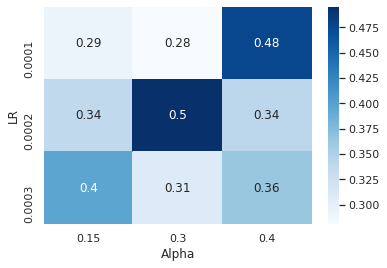

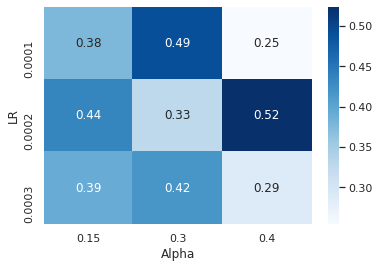

In [0]:
max_validation_accuracy_cartoon = dict()
max_validation_accuracy_sketch = dict()

for key in validation_accuracies_cartoon:
    max_validation_accuracy_cartoon[key] = sorted(validation_accuracies_cartoon[key], reverse=True)[0]

for key in validation_accuracies_sketch:   
    max_validation_accuracy_sketch[key] = sorted(validation_accuracies_sketch[key], reverse=True)[0]

grid_search_cartoon = []
for key in max_validation_accuracy_cartoon:
    grid_search_cartoon.append( (key[0], key[1], max_validation_accuracy_cartoon[key]) )
    
cartoon = pd.DataFrame(grid_search_cartoon, columns =['LR', 'Alpha', 'Accuracy'])
cartoon_pivot = cartoon.pivot(index='LR', columns='Alpha', values='Accuracy')
ax = sns.heatmap(cartoon_pivot,annot=True, cmap="Blues")

plt.show()

grid_search_sketch = []
for key in max_validation_accuracy_sketch:
    grid_search_sketch.append( (key[0], key[1], max_validation_accuracy_sketch[key]) )
    
sketch = pd.DataFrame(grid_search_sketch, columns =['LR', 'Alpha', 'Accuracy'])
sketch_pivot = sketch.pivot(index='LR', columns='Alpha', values='Accuracy')
ax = sns.heatmap(sketch_pivot,annot=True, cmap="Blues")



In [0]:
avg_validation_accuracy = dict()

for key in max_validation_accuracy_cartoon:
    avg_validation_accuracy[key] = (max_validation_accuracy_cartoon[key] + max_validation_accuracy_sketch[key]) / 2

lr, alpha = [key for key in avg_validation_accuracy if avg_validation_accuracy[key] == sorted(avg_validation_accuracy.values(), reverse=True)[0]][0]

print(lr, alpha) # Best Parameters

0.0002 0.4


<Figure size 432x288 with 0 Axes>

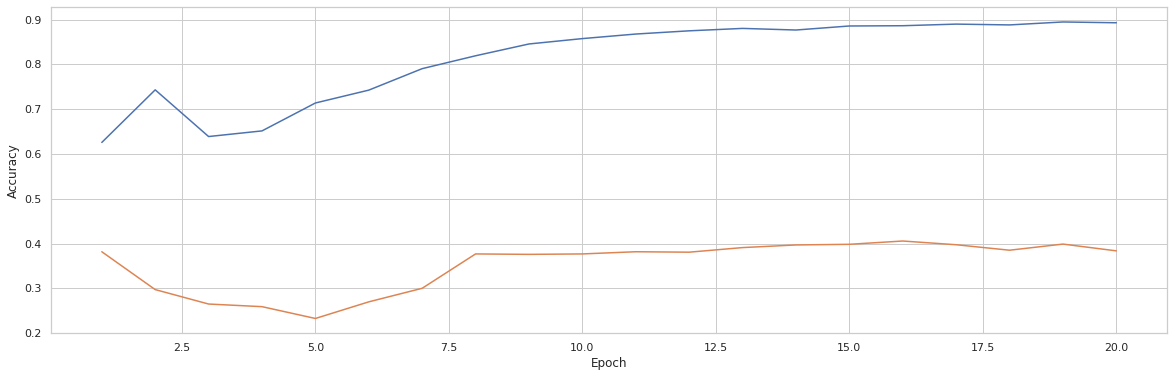

<Figure size 432x288 with 0 Axes>

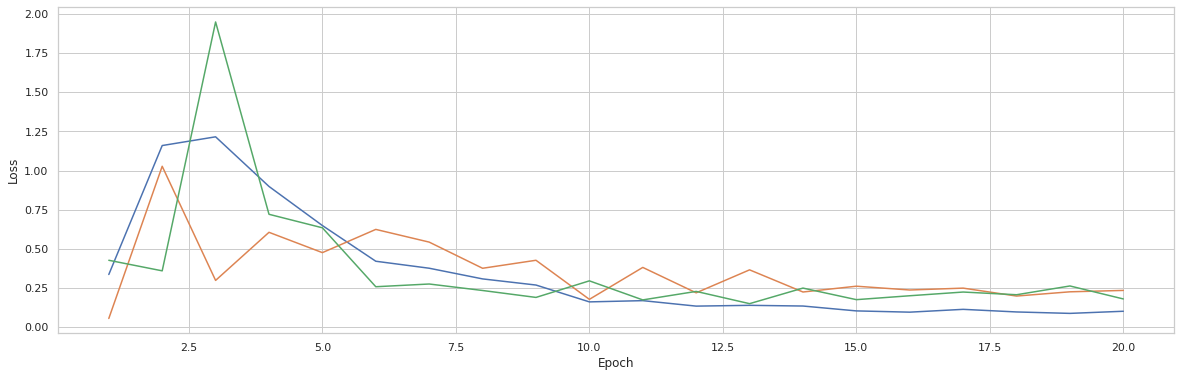

In [0]:
DEVICE, NUM_CLASSES, NUM_DOMAINS, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, IMAGE_SIZE = loader.load_default_parameters()

LR = lr
LAMBDA = alpha

train_dataset, test_dataset, cartoon_dataset, sketch_dataset = loader.load_datasets()
dataloader_source, dataloader_target, dataloader_target_cartoon, dataloader_target_sketch = loader.load_dataloaders()

dann = loader.load_dann(RandomNetworkWithReverseGrad.alexnet_dann(pretrained=True))
loss_classifier, loss_discriminator = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
optimizer, scheduler = loader.load_scheduler_optimizer(dann, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = optimizer_name)


discriminator_source_labels, discriminator_target_labels  = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE), torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) # Discriminator label to Photo, Discriminator label to Art Painting
discriminator_labels = torch.cat([discriminator_source_labels, discriminator_target_labels], dim=0)

manager.train_network_with_adaptation_artpainting(dann, util, LAMBDA)

model_filename = "model_lr_" + str(LR).replace(".", "") + "_alpha_" + str(LAMBDA).replace(".", "") + ".pth"
model_path = F"/content/drive/My Drive/Colab Notebooks/HW3/{optimizer_name}/hyperparameters_tuning_artpainting/{model_filename}"
torch.save(dann.state_dict(), model_path)

In [0]:
manager.test_network(dann, dataloader_target)

Test Accuracy: 0.3837890625


### Code

In [0]:
class Loader():
  def __init__(self):
    pass

  def load_default_parameters(self):
    default_DEVICE = 'cuda'
    default_NUM_CLASSES = 7
    default_NUM_DOMAINS = 2 
    default_BATCH_SIZE = 256 
    default_LR = 0.0001           
    default_MOMENTUM = 0.9      
    default_WEIGHT_DECAY = 5e-5  
    default_NUM_EPOCHS = 20
    default_STEP_SIZE = 10  
    default_GAMMA = 0.2    
    default_LOG_FREQUENCY = 10
    default_IMAGE_SIZE = 224
    return (default_DEVICE, default_NUM_CLASSES, default_NUM_DOMAINS, default_BATCH_SIZE, default_LR, default_MOMENTUM, default_WEIGHT_DECAY, default_NUM_EPOCHS, default_STEP_SIZE, default_GAMMA, default_LOG_FREQUENCY, default_IMAGE_SIZE)
    pass

  def load_hyperparameters_tuning_parameters(self):
    ht_DEVICE = 'cuda'
    ht_NUM_CLASSES = 7
    ht_NUM_DOMAINS = 2 
    ht_BATCH_SIZE = 256 
    ht_LR = 0.0001           
    ht_MOMENTUM = 0.9      
    ht_WEIGHT_DECAY = 5e-5  
    ht_NUM_EPOCHS = 8
    ht_STEP_SIZE = 4  
    ht_GAMMA = 0.2    
    ht_LOG_FREQUENCY = 10
    ht_IMAGE_SIZE = 224
    return (ht_DEVICE, ht_NUM_CLASSES, ht_NUM_DOMAINS, ht_BATCH_SIZE, ht_LR, ht_MOMENTUM, ht_WEIGHT_DECAY, ht_NUM_EPOCHS, ht_STEP_SIZE, ht_GAMMA, ht_LOG_FREQUENCY, ht_IMAGE_SIZE)
    pass
  
  def load_hyperparameters_set_with_adaptation_training(self):
    return [[0.0001, 0.0002, 0.0003], [0.15, 0.3, 0.4]] # [LR, Lambda]
    pass

  def load_hyperparameters_set_without_adaptation_training(self):
    return [[0.0001, 0.001, 0.005, 0.01],["SGD", "Adam"]] # [LR, Optimizer]
    pass

  def load_default_transformations(self):
    return (transforms.Compose([
      transforms.Resize(256),      
      transforms.CenterCrop(224),                            
      transforms.ToTensor(), 
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ]),
    transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
    ]))
    pass

  def clone_repositories(self):
    # Clone github repository with data
    if not os.path.isdir('./PACS'):
      !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
      !mv 'Homework3-PACS' 'PACS'

    # Clone personal github repository with DANN model class
    if not os.path.isdir('./DANN'):
      !git clone https://github.com/cpeluso/HW3-Deep-Domain-Adaptation.git
      !mv 'HW3-Deep-Domain-Adaptation' 'DANN'
    
    pass

  def load_datasets(self):
    global train_transform, test_transform

    DATA_DIR = [
      "PACS/PACS/art_painting",
      "PACS/PACS/cartoon",
      "PACS/PACS/photo",
      "PACS/PACS/sketch"
    ]

    return (ImageFolder(DATA_DIR[2], transform = train_transform),
            ImageFolder(DATA_DIR[0], transform = test_transform),
            ImageFolder(DATA_DIR[1], transform = test_transform),
            ImageFolder(DATA_DIR[3], transform = test_transform))
    pass

  def load_dataloaders(self):
    global train_dataset, test_dataset, cartoon_dataset, sketch_dataset
    
    return (DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True),
            DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
            DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
            DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4))
    pass

  def load_dann(self, dann):
    # Apply weights of pretrained AlexNet also to the domain classifier branch
    for classifier_layer, dann_classifier_layer in zip(dann.classifier, dann.dann_classifier):
      if type(classifier_layer) is torch.nn.modules.linear.Linear:
        dann_classifier_layer.weight.data = classifier_layer.weight.data
        dann_classifier_layer.bias.data = classifier_layer.bias.data

    # Change number of outputs of last fully connected layers of classifier and domain classifier
    dann.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    dann.dann_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

    return dann
    pass

  def load_scheduler_optimizer(self, dann, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, optimizer_name = "SGD"):

    parameters_to_optimize = dann.parameters()

    if optimizer_name == "Adam":
      optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
    elif optimizer_name == "SGD":
      optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    return optimizer, scheduler 
    pass

In [0]:
class Utility():
  def __init__(self):
    pass

  def sample_target(self, step, n_batches):
    global dataloader_target
    if step % n_batches == 0:
        self.target_set = iter(dataloader_target)
    return self.target_set.next()
    pass

  def sample_target_cartoon(self, step, n_batches):
    global dataloader_target_cartoon
    if step % n_batches == 0:
        self.target_set_cartoon = iter(dataloader_target_cartoon)
    return self.target_set_cartoon.next()
    pass

  def sample_target_sketch(self, step, n_batches):
    global dataloader_target_sketch
    if step % n_batches == 0:
        self.target_set_sketch = iter(dataloader_target_sketch)
    return self.target_set_sketch.next()
    pass
    
  def plot_losses(self, classifier_losses = [], discriminator_source_losses = [], discriminator_target_losses = []):

    plt.figure()  
    sns.set(style = "whitegrid")
    fig, ax = plt.subplots(figsize=(20, 6))

    if classifier_losses != []:
      classifier_loss_df = pd.DataFrame(classifier_losses)
      classifier_loss_df = classifier_loss_df.astype(float)
      classifier_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=classifier_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")

    if discriminator_source_losses != []:
      discriminator_source_loss_df = pd.DataFrame(discriminator_source_losses)
      discriminator_source_loss_df = discriminator_source_loss_df.astype(float)
      discriminator_source_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=discriminator_source_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")
    
    if discriminator_target_losses != []:
      discriminator_target_loss_df = pd.DataFrame(discriminator_target_losses)
      discriminator_target_loss_df = discriminator_target_loss_df.astype(float)
      discriminator_target_loss_df.columns=['Epoch','Loss']
      sns.lineplot(x='Epoch',y='Loss',data=discriminator_target_loss_df, markers=True, dashes=False,  ax = ax, legend = "full")

    pass

  def plot_accuracies(self, classifier_accuracies = [], validation_accuracies = []):
    
    plt.figure()  
    sns.set(style = "whitegrid")
    fig, ax = plt.subplots(figsize=(20, 6))

    classifier_accuracies_df = pd.DataFrame(classifier_accuracies)
    classifier_accuracies_df = classifier_accuracies_df.astype(float)
    classifier_accuracies_df.columns=['Epoch','Accuracy']

    validation_accuracies_df = pd.DataFrame(validation_accuracies)
    validation_accuracies_df = validation_accuracies_df.astype(float)
    validation_accuracies_df.columns=['Epoch','Accuracy']

    sns.lineplot(x='Epoch',y='Accuracy',data=classifier_accuracies_df, markers=True, dashes=False,  ax = ax)
    sns.lineplot(x='Epoch',y='Accuracy',data=validation_accuracies_df, markers=True, dashes=False,  ax = ax)

    pass
  
  

In [0]:
class TrainValidateTestManager():
  def __init__(self):
    pass
  
  def train_network_without_adaptation_artpainting(self, dann, util):
    global dataloader_source, train_dataset, NUM_EPOCHS, optimizer, scheduler
    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    validation_accuracies = []
    classifier_losses = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        source = source_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      validation_accuracy = self.evaluate_neural_network_on_validation_set(dann, dataloader_target, test_dataset)
      
      print("Classifier accuracy: ", str(accuracy))
      print("Validation accuracy: ", str(validation_accuracy))
      print("Classifier loss: ", str(classifier_loss.item()))

      classifier_accuracies.append( (epoch + 1, accuracy) )
      validation_accuracies.append( (epoch + 1, validation_accuracy) )
      classifier_losses.append( (epoch + 1, classifier_loss.item()) )

    output.clear()    
    util.plot_accuracies(classifier_accuracies, validation_accuracies)
    util.plot_losses(classifier_losses)
    pass

  def train_network_without_adaptation_cartoon(self, dann, util):
    global dataloader_source, train_dataset, NUM_EPOCHS, optimizer, scheduler, dataloader_target_cartoon, cartoon_dataset
    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    validation_accuracies = []
    classifier_losses = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        source = source_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      validation_accuracy = self.evaluate_neural_network_on_validation_set(dann, dataloader_target_cartoon, cartoon_dataset)
      validation_accuracies.append(validation_accuracy)

      print("Classifier accuracy: ", str(accuracy))
      print("Validation accuracy: ", str(validation_accuracy))
      print("Classifier loss: ", str(classifier_loss.item()))

    output.clear()

    return validation_accuracies
    pass
  
  def train_network_without_adaptation_sketch(self, dann, util):
    global dataloader_source, train_dataset, NUM_EPOCHS, optimizer, scheduler, dataloader_target_sketch, sketch_dataset
    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    validation_accuracies = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        source = source_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      validation_accuracy = self.evaluate_neural_network_on_validation_set(dann, dataloader_target_sketch, sketch_dataset)
      validation_accuracies.append(validation_accuracy)

      print("Classifier accuracy: ", str(accuracy))
      print("Validation accuracy: ", str(validation_accuracy))
      print("Classifier loss: ", str(classifier_loss.item()))

    output.clear()

    return validation_accuracies
    pass


  
  def train_network_with_adaptation_artpainting(self, dann, util, LAMBDA):
    global dataloader_source, train_dataset, NUM_EPOCHS, BATCH_SIZE, optimizer, scheduler
    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    validation_accuracies = []
    classifier_losses = []
    discriminator_source_losses = []
    discriminator_target_losses = []
    short_discriminator_target_labels = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        target_images, target_set = util.sample_target(current_step, BATCH_SIZE)

        source = source_images.to(DEVICE)
        target = target_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        # Forward source data to the discriminator branch of the network
        discriminator_output_source = dann(source, LAMBDA)
        discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
        discriminator_loss_source.backward()

        # Forward target data to the discriminator branch of the network
        discriminator_output_target = dann(target, LAMBDA)
        if BATCH_SIZE != len(discriminator_output_target):

          # Define short_discriminator_target_labels if not defined yet
          short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE) if len(short_discriminator_target_labels) else short_discriminator_target_labels
        
          discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
      
        else:
          
          discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)

        discriminator_loss_target.backward()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      validation_accuracy = self.evaluate_neural_network_on_validation_set(dann, dataloader_target, test_dataset)
      
      print("Classifier accuracy: ", str(accuracy))
      print("Validation accuracy: ", str(validation_accuracy))
      print("Classifier loss: ", str(classifier_loss.item()))
      print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))
      print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

      classifier_accuracies.append( (epoch + 1, accuracy) )
      validation_accuracies.append( (epoch + 1, validation_accuracy) )
      classifier_losses.append( (epoch + 1, classifier_loss.item()) )
      discriminator_source_losses.append( (epoch + 1, discriminator_loss_source.item()) )
      discriminator_target_losses.append( (epoch + 1, discriminator_loss_target.item()) )

    output.clear()
    util.plot_accuracies(classifier_accuracies, validation_accuracies)
    util.plot_losses(classifier_losses, discriminator_source_losses, discriminator_target_losses)
    pass

  def train_network_with_adaptation_cartoon(self, dann, util, LAMBDA):
    global dataloader_source, train_dataset, NUM_EPOCHS, BATCH_SIZE, dataloader_target_cartoon, cartoon_dataset, optimizer, scheduler

    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    validation_accuracies = []
    classifier_losses = []
    discriminator_source_losses = []
    discriminator_target_losses = []
    short_discriminator_target_labels = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        target_images, target_set = util.sample_target_cartoon(current_step, BATCH_SIZE)

        source = source_images.to(DEVICE)
        target = target_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        # Forward source data to the discriminator branch of the network
        discriminator_output_source = dann(source, LAMBDA)
        discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
        discriminator_loss_source.backward()

        # Forward target data to the discriminator branch of the network
        discriminator_output_target = dann(target, LAMBDA)
        if BATCH_SIZE != len(discriminator_output_target):

          # Define short_discriminator_target_labels if not defined yet
          short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE) if len(short_discriminator_target_labels) else short_discriminator_target_labels
        
          discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
      
        else:
          
          discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)

        discriminator_loss_target.backward()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      
      print("Classifier accuracy: ", str(accuracy))

      validation_accuracy = self.evaluate_neural_network_on_validation_set(dann, dataloader_target_cartoon, cartoon_dataset)
      validation_accuracies.append(validation_accuracy)
      print("Validation accuracy: ", str(validation_accuracy))
      
      print("Classifier loss: ", str(classifier_loss.item()))
      print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))
      print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

    output.clear()

    return validation_accuracies
    pass

  def train_network_with_adaptation_sketch(self, dann, util, LAMBDA):
    global dataloader_source, train_dataset, NUM_EPOCHS, BATCH_SIZE, dataloader_target_sketch, sketch_dataset, optimizer, scheduler

    dann = dann.to(DEVICE) 
    cudnn.benchmark
    current_step = 0

    classifier_accuracies = []
    validation_accuracies = []
    classifier_losses = []
    discriminator_source_losses = []
    discriminator_target_losses = []
    short_discriminator_target_labels = []

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      
      print("Epoch " + str(epoch+1))
      
      running_corrects = 0

      for index, (source_images, labels) in enumerate(dataloader_source):

        dann.train()

        target_images, target_set = util.sample_target_sketch(current_step, BATCH_SIZE)

        source = source_images.to(DEVICE)
        target = target_images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward source data to the classifier branch of the network
        classifier_output = dann(source)
        classifier_loss = loss_classifier(classifier_output, labels)
        classifier_loss.backward()

        # Get predictions
        _, preds = torch.max(classifier_output.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        # Forward source data to the discriminator branch of the network
        discriminator_output_source = dann(source, LAMBDA)
        discriminator_loss_source = loss_discriminator(discriminator_output_source, discriminator_source_labels)
        discriminator_loss_source.backward()

        # Forward target data to the discriminator branch of the network
        discriminator_output_target = dann(target, LAMBDA)
        if BATCH_SIZE != len(discriminator_output_target):

          # Define short_discriminator_target_labels if not defined yet
          short_discriminator_target_labels = torch.zeros(len(discriminator_output_target), dtype = torch.long).to(DEVICE) if len(short_discriminator_target_labels) else short_discriminator_target_labels
        
          discriminator_loss_target = loss_discriminator(discriminator_output_target, short_discriminator_target_labels)
      
        else:
          
          discriminator_loss_target = loss_discriminator(discriminator_output_target, discriminator_target_labels)

        discriminator_loss_target.backward()

        optimizer.step()

      scheduler.step() 

      # Calculate Accuracy
      accuracy = running_corrects / float(len(train_dataset))
      
      print("Classifier accuracy: ", str(accuracy))

      validation_accuracy = self.evaluate_neural_network_on_validation_set(dann, dataloader_target_sketch, sketch_dataset)
      validation_accuracies.append(validation_accuracy)
      print("Validation accuracy: ", str(validation_accuracy))
      
      print("Classifier loss: ", str(classifier_loss.item()))
      print("Discriminator (source) loss: ", str(discriminator_loss_source.item()))
      print("Discriminator (target) loss: ", str(discriminator_loss_target.item()))

    output.clear()

    return validation_accuracies
    pass
  
  def evaluate_neural_network_on_validation_set(self, dann, dataloader_target, target_dataset):
    dann.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in dataloader_target:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = dann(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(target_dataset))

    return accuracy
    pass

  def test_network(self, dann, dataloader_target):

    # Set Network to evaluation mode
    dann.train(False) 

    running_corrects = 0
    for images, labels in tqdm(dataloader_target):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = dann(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    print('\nTest Accuracy: {}'.format(accuracy))
    pass
